# Replicating Education Crowdfunding Results


### What is this?
This notebook provides step-by-step instructions for replicating the results from our recent study of fairness-accuracy trade-offs on the Education Crowdfunding dataset.

### What has already been done?
To make reproducing the bias analysis easier as well as provide more visibility into our results, this notebook starts off from a point where the public DonorsChoose dataset has already been injested into a postgres database and a grid of models (described in Supplementary Table 2 of our study) has already been run. We've made available a database dump with both the underlying data and the results of our model runs (see below for instructions on getting it set up).

### What if I want to re-run the models from scratch?
You can also re-run (or add to) the model grid starting from the public DonorsChoose data using our open-source machine learning pipeline `triage`, which makes it easier to run any model with a `scikit-learn`-style interface over temporal validation sets in a "top k" setting. See this repo's readme file for some tips on getting set up as well as pointers to a repo with an example of running triage using these data.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
import yaml
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None

from IPython.display import display 
from itertools import permutations
from jinja2 import Template
import dateparser


from ohio.ext.numpy import pg_copy_to_table

## Getting Set Up

We've provided an extract of the data in a postgres dump file (postgres 11.10), available at: 

https://dsapp-public-data-migrated.s3.amazonaws.com/education_crowdfunding_replication.dmp 

(NOTE: this file is about 16 GB compressed, so may take some time to download depending on your connection). You can load the data into your own postgres server using (you'll need to create the `education_crowdfunding` database first and fill in the host, port, and user below):

```bash
pg_restore -h {POSTGRES_HOST} -p {POSTGRES_PORT} -d education_crowdfunding -U {POSTGRES_USER} -O -j 8 education_crowdfunding_replication.dmp
```

Note that the dump file is compressed and you'll need a server with around 500 GB of free disk space.

Loading this file will populate your database with several schemas:
- **public**: The raw data from donors choose as well as some tables with calculated features and intermediate modeling tables
- **model_metadata**: Information about the models we ran, such as model types and hyperparameters (models were run with `triage`, which generates this schema. In `triage` a "model group" specifies a type of model and associated hyperparameter values, while a "model" is an instantiation of a given model group on a specific temporal validation split). Note that this schema contains information on other model runs with this dataset, in addition to the run used for the current study of fairness-accuracy trade-offs.
- **test_results**: Validation set statistics and predictions for the models. Here, `test_results.predictions` contains project-level predicted scores from each model in the grid, while `test_results.evaluations` contains aggregated summary statistics for each model.
- **train_results**: Training set statistics for the models, including feature importances.
- **features**: Intermediate tables containing calculated features from the `triage` run.
- **bias_working**: Intermediate tables from the bias analysis, as well as the mapping table between projects and school poverty levels, `bias_working.entity_demos`.
- **bias_results_submitted**: Results of the fairness-accuracy trade-offs from the study as submitted (see below to use these to replicate the figures from the study).
- **bias_results**: Empty bias analysis results tables that will be populated by re-running the fairness adjustments (see below for instructions).


Finally, to connect to the database, you'll need a yaml file named `db_profile.yaml` in the same directory as this notebook with your connection info:
```yaml
host: {POSTGRES_HOST}
user: {POSTGRES_USER}
db: education_crowdfunding
pass: {POSTGRES_PASSWORD}
port: {POSTGRES_PORT}
```


In [2]:
with open('db_profile.yaml') as fd:
    config = yaml.full_load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgresql",
        host=config["host"],
        username=config["user"],
        database=config["db"],
        password=config["pass"],
        port=config["port"],
    )
    engine_donors = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

/tmp/ipykernel_9660/636033927.py:3: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  dburl = sqlalchemy.engine.url.URL(


Next, we define a helper function that will pull the results of the various strategies explored in the study. The table `model_adjustment_results_plevel` contains performance statistics for each model type we ran with and without adjusting for recall equity and `composite_results_plevel` contains performance statistics for a stategy that selects the best-performing model for each subgroup separately (we'll look at generating these tables from the raw modeling results as well below). The query below uses four different strategies to choose a model for each temporal validation split based on these performance statistics:

In [85]:
def get_bias_results(engine, schema='bias_results', mg_table='model_adjustment_results_plevel', table='model_adjustment_results_plevel', self_adjustment=False):
    comparator = ">"
    if self_adjustment:
        comparator = "="
    sql = f"""
    WITH mg_rns AS (
      SELECT *,
             row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
             row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj, 
             row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_multi_adj
      FROM {schema}.{mg_table}
      WHERE past_train_end_time = train_end_time
    )
    , base_mgs AS (
      SELECT * FROM mg_rns WHERE rn_base = 1
    )
    , adj_mgs AS (
      SELECT * FROM mg_rns WHERE rn_adj = 1
    )
    , multi_adj_mgs AS (
      SELECT * FROM mg_rns WHERE rn_adj = 1
    )
    -- Simple model selection on last time period, baseline with no recall adjustments
    SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.base_value AS value,
           r.base_max_recall_ratio AS max_recall_ratio,
           r.base_recall_not_highest_to_highest AS recall_not_highest_to_highest,
           r.base_frac_not_highest AS frac_not_highest,
           r.base_frac_highest AS frac_highest,
           r.base_min_score_not_highest AS min_score_not_highest, 
           r.base_min_score_highest AS min_score_highest, 
           r.base_mean_score_not_highest AS mean_score_not_highest, 
           r.base_mean_score_highest AS mean_score_highest,
           r.base_precision_not_highest AS precision_not_highest, 
           r.base_precision_highest AS precision_highest, 
           r.base_prevalence_not_highest AS prevalence_not_highest, 
           r.base_prevalence_highest AS prevalence_highest, 
           r.base_positive_prevalence_not_highest AS positive_prevalence_not_highest, 
           r.base_positive_prevalence_highest AS positive_prevalence_highest,            
           r.base_positive_rate_not_highest AS positive_rate_not_highest, 
           r.base_positive_rate_highest AS positive_rate_highest
    FROM {schema}.{table} r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time

    UNION ALL

    -- Model selection on last time before adjustment, with adjustment applied
    SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.adj_value AS value,
           r.adj_max_recall_ratio AS max_recall_ratio,
           r.adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
           r.adj_frac_not_highest AS frac_not_highest,
           r.adj_frac_highest AS frac_highest, 
           r.adj_min_score_not_highest AS min_score_not_highest, 
           r.adj_min_score_highest AS min_score_highest, 
           r.adj_mean_score_not_highest AS mean_score_not_highest, 
           r.adj_mean_score_highest AS mean_score_highest, 
           r.adj_precision_not_highest AS precision_not_highest, 
           r.adj_precision_highest AS precision_highest, 
           r.adj_prevalence_not_highest AS prevalence_not_highest, 
           r.adj_prevalence_highest AS prevalence_highest, 
           r.adj_positive_prevalence_not_highest AS positive_prevalence_not_highest, 
           r.adj_positive_prevalence_highest AS positive_prevalence_highest, 
           r.adj_positive_rate_not_highest AS positive_rate_not_highest, 
           r.adj_positive_rate_highest AS positive_rate_highest
    FROM {schema}.{table} r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time

    UNION ALL

    -- Model selection on last time after adjustment, with adjustment applied
    SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.adj_value AS value,
           r.adj_max_recall_ratio AS max_recall_ratio,
           r.adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
           r.adj_frac_not_highest AS frac_not_highest,
           r.adj_frac_highest AS frac_highest, 
           r.adj_min_score_not_highest AS min_score_not_highest, 
           r.adj_min_score_highest AS min_score_highest, 
           r.adj_mean_score_not_highest AS mean_score_not_highest, 
           r.adj_mean_score_highest AS mean_score_highest, 
           r.adj_precision_not_highest AS precision_not_highest, 
           r.adj_precision_highest AS precision_highest, 
           r.adj_prevalence_not_highest AS prevalence_not_highest, 
           r.adj_prevalence_highest AS prevalence_highest, 
           r.adj_positive_prevalence_not_highest AS positive_prevalence_not_highest, 
           r.adj_positive_prevalence_highest AS positive_prevalence_highest, 
           r.adj_positive_rate_not_highest AS positive_rate_not_highest, 
           r.adj_positive_rate_highest AS positive_rate_highest
    FROM {schema}.{table} r
    JOIN adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time
    
    UNION ALL

    -- Model selection on last time before multiple adjustment, with multiple adjustment applied
    SELECT 'Best Unadjusted Metric - MultiAdjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.multi_adj_value AS value,
           r.multi_adj_max_recall_ratio AS max_recall_ratio,
           r.multi_adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
           r.multi_adj_frac_not_highest AS frac_not_highest,
           r.multi_adj_frac_highest AS frac_highest, 
           r.multi_adj_min_score_not_highest AS min_score_not_highest, 
           r.multi_adj_min_score_highest AS min_score_highest, 
           r.multi_adj_mean_score_not_highest AS mean_score_not_highest, 
           r.multi_adj_mean_score_highest AS mean_score_highest, 
           r.multi_adj_precision_not_highest AS precision_not_highest, 
           r.multi_adj_precision_highest AS precision_highest, 
           r.multi_adj_prevalence_not_highest AS prevalence_not_highest, 
           r.multi_adj_prevalence_highest AS prevalence_highest, 
           r.multi_adj_positive_prevalence_not_highest AS positive_prevalence_not_highest, 
           r.multi_adj_positive_prevalence_highest AS positive_prevalence_highest, 
           r.multi_adj_positive_rate_not_highest AS positive_rate_not_highest, 
           r.multi_adj_positive_rate_highest AS positive_rate_highest
    FROM {schema}.{table} r
    JOIN base_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time
    
    
        UNION ALL

    -- Model selection on last time after multiple adjustment, with multiple adjustment applied
    SELECT 'Best Multi Adjusted Metric - MultiAdjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.multi_adj_value AS value,
           r.multi_adj_max_recall_ratio AS max_recall_ratio,
           r.multi_adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
           r.multi_adj_frac_not_highest AS frac_not_highest,
           r.multi_adj_frac_highest AS frac_highest, 
           r.multi_adj_min_score_not_highest AS min_score_not_highest, 
           r.multi_adj_min_score_highest AS min_score_highest, 
           r.multi_adj_mean_score_not_highest AS mean_score_not_highest, 
           r.multi_adj_mean_score_highest AS mean_score_highest, 
           r.multi_adj_precision_not_highest AS precision_not_highest, 
           r.multi_adj_precision_highest AS precision_highest, 
           r.multi_adj_prevalence_not_highest AS prevalence_not_highest, 
           r.multi_adj_prevalence_highest AS prevalence_highest, 
           r.multi_adj_positive_prevalence_not_highest AS positive_prevalence_not_highest, 
           r.multi_adj_positive_prevalence_highest AS positive_prevalence_highest, 
           r.multi_adj_positive_rate_not_highest AS positive_rate_not_highest, 
           r.multi_adj_positive_rate_highest AS positive_rate_highest
    FROM {schema}.{table} r
    JOIN multi_adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time
    
    UNION ALL

    -- Model selection on last time after multiple adjustment, with multiple adjustment applied
    SELECT 'Best Adjusted Metric - MultiAdjusted'::VARCHAR(128) AS strategy,
           r.train_end_time, r.past_train_end_time,
           r.list_size, r.metric, r.parameter,
           r.multi_adj_value AS value,
           r.multi_adj_max_recall_ratio AS max_recall_ratio,
           r.multi_adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
           r.multi_adj_frac_not_highest AS frac_not_highest,
           r.multi_adj_frac_highest AS frac_highest, 
           r.multi_adj_min_score_not_highest AS min_score_not_highest, 
           r.multi_adj_min_score_highest AS min_score_highest, 
           r.multi_adj_mean_score_not_highest AS mean_score_not_highest, 
           r.multi_adj_mean_score_highest AS mean_score_highest, 
           r.multi_adj_precision_not_highest AS precision_not_highest, 
           r.multi_adj_precision_highest AS precision_highest, 
           r.multi_adj_prevalence_not_highest AS prevalence_not_highest, 
           r.multi_adj_prevalence_highest AS prevalence_highest, 
           r.multi_adj_positive_prevalence_not_highest AS positive_prevalence_not_highest, 
           r.multi_adj_positive_prevalence_highest AS positive_prevalence_highest, 
           r.multi_adj_positive_rate_not_highest AS positive_rate_not_highest, 
           r.multi_adj_positive_rate_highest AS positive_rate_highest
    FROM {schema}.{table} r
    JOIN adj_mgs b
      ON r.model_group_id = b.model_group_id
      AND r.past_train_end_time = b.train_end_time
      AND r.list_size = b.list_size
      AND r.metric = b.metric
      AND r.parameter = b.parameter
    WHERE r.train_end_time {comparator} r.past_train_end_time

    UNION ALL

    -- Composite model
    SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
          train_end_time, past_train_end_time,
          list_size, metric, parameter,
          value,
          max_recall_ratio,
          recall_not_highest_to_highest,
          frac_not_highest,
          frac_highest, 
          min_score_not_highest, 
          min_score_highest, 
          mean_score_not_highest, 
          mean_score_highest, 
          precision_not_highest, 
          precision_highest, 
          prevalence_not_highest, 
          prevalence_highest, 
          positive_prevalence_not_highest, 
          positive_prevalence_highest, 
          positive_rate_not_highest, 
          positive_rate_highest
    FROM {schema}.composite_results_plevel
    WHERE train_end_time {comparator} past_train_end_time
    ;
    """

    ts_df = pd.read_sql(sql, engine)

    ts_df['dataset'] = 'Education Crowdfunding'

    ts_df['strategy'] = ts_df['strategy'].map({
        'Best Unadjusted Metric - Unadjusted': 'Unmitigated', 
        'Best Adjusted Metric - Adjusted': 'Mitigated - Single Model', 
        'Best Adjusted Metric - MultiAdjusted': 'MultiMitigated - Adj Seln.',
        'Best Multi Adjusted Metric - MultiAdjusted': 'MultiMitigated - MAdj Seln.',
        'Composite Model - Adjusted': 'Mitigated - Composite Model',
        'Best Unadjusted Metric - Adjusted': 'Mitigated - Unadj. Model Seln.', 
        'Best Unadjusted Metric - MultiAdjusted': "MultiMitigated - Unadj. Model Seln."        
    })
    
    return ts_df

In [86]:
def get_merged_bias_results(engine, schema="bias_results"):
    df = get_bias_results(engine, mg_table="save_res_a", table="save_res_a")
    df["weight"] = 0.99
    w = 1
    for i, tname in enumerate(["b", "c", "d", "e", "f", "g", "h", "i", "j", "k"]):
        w = w - 0.1
        tmp_df = get_bias_results(engine, schema=schema, mg_table=f"save_res_{tname}", table=f"save_res_{tname}")
        if tname != "k":
            tmp_df["weight"] = w
        else:
            tmp_df["weight"] = 0.01
        df = df.append(tmp_df, ignore_index=True)
            
    return df
    

In [87]:
def get_exhaustive_results(engine, schema="bias_results"):
    import string
    df = get_bias_results(engine, table="exhaustive_a")
    df["ex_id"] = "a"
    for alph in string.ascii_lowercase[1:10]:
        tmp_df = get_bias_results(engine, table=f"exhaustive_{alph}")
        tmp_df["ex_id"] = alph
        df = df.append(tmp_df, ignore_index=True)
    return df

## Reproducing Figures from the Study

As a starting point, we can reproduce the figures from the study directly using the data in the `bias_results_submitted` schema:

In [124]:
ts_df3 = get_bias_results(engine_donors, schema='bias_results')
self_adjustment_df = get_bias_results(engine_donors, schema='bias_results', self_adjustment=True)
self_adjustment_df = self_adjustment_df[self_adjustment_df["strategy"] == "Mitigated - Single Model"]
self_adjustment_df["strategy"] = "Self Adjusted"
ts_df3 = ts_df3.append(self_adjustment_df, ignore_index=True)
print(ts_df3.columns)

Index(['strategy', 'train_end_time', 'past_train_end_time', 'list_size',
       'metric', 'parameter', 'value', 'max_recall_ratio',
       'recall_not_highest_to_highest', 'frac_not_highest', 'frac_highest',
       'min_score_not_highest', 'min_score_highest', 'mean_score_not_highest',
       'mean_score_highest', 'precision_not_highest', 'precision_highest',
       'prevalence_not_highest', 'prevalence_highest',
       'positive_prevalence_not_highest', 'positive_prevalence_highest',
       'positive_rate_not_highest', 'positive_rate_highest', 'dataset'],
      dtype='object')


/tmp/ipykernel_9660/1679617509.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ts_df3 = ts_df3.append(self_adjustment_df, ignore_index=True)


In [125]:
import matplotlib.dates as mdates

months = mdates.MonthLocator([1,3,5,7,9,11])
months_fmt = mdates.DateFormatter('%b %y')

In [139]:
def line_plot_over_time(y, y_label, ax=None, strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln."]):
    if strategies is None:
        df = ts_df3
    else:
        df = ts_df3.loc[ts_df3["strategy"].isin(strategies), ]
    if len(strategies) == 1:
        hue = None
    else:
        hue = "strategy"
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df, x='train_end_time', y=y, hue=hue, marker="o", ax=ax)

    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel('Test Set Date', fontsize=14)

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.get_legend()
    return ax

In [140]:
def line_plots_over_time(ys, y_labels, ax=None, strategies=["Unmitigated", "Mitigated - Single Model"], df=None):
    if strategies is None:
        df = ts_df3
    else:
        df = ts_df3.loc[ts_df3["strategy"].isin(strategies), ]    
    if len(strategies) == 1:
        hue = None
    else:
        hue = "strategy"
    markers = ["*", "o", "s", "^", "P"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    for i, y in enumerate(ys):
        y_label = y_labels[i]
        marker = markers[i]
        sns.lineplot(data=df, x='train_end_time', y=y, hue=hue, marker=marker, ax=ax, label=y_label)
    ax.set_xlabel('Test Set Date', fontsize=14)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    ax.get_legend()
    
    return ax

### Supplementary Figure 3
Comparing model precision (a) and disparity (b) metrics over time fordifferent model selection strategies in the Education Crowdfunding policy context.

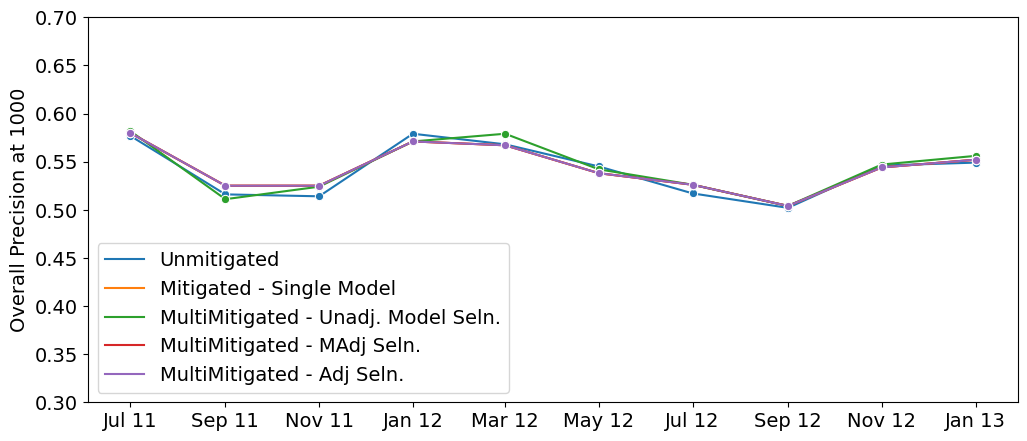

In [144]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.loc[~ts_df3['strategy'].isin(['Mitigated - Unadj. Model Seln.', "Self Adjusted"]), ], x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.30,0.70))
ax.set_ylabel('Overall Precision at 1000', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=1, fontsize=14, loc='lower left')

<AxesSubplot: xlabel='Test Set Date', ylabel='Recall Disparity:\nLower to Higher Poverty'>

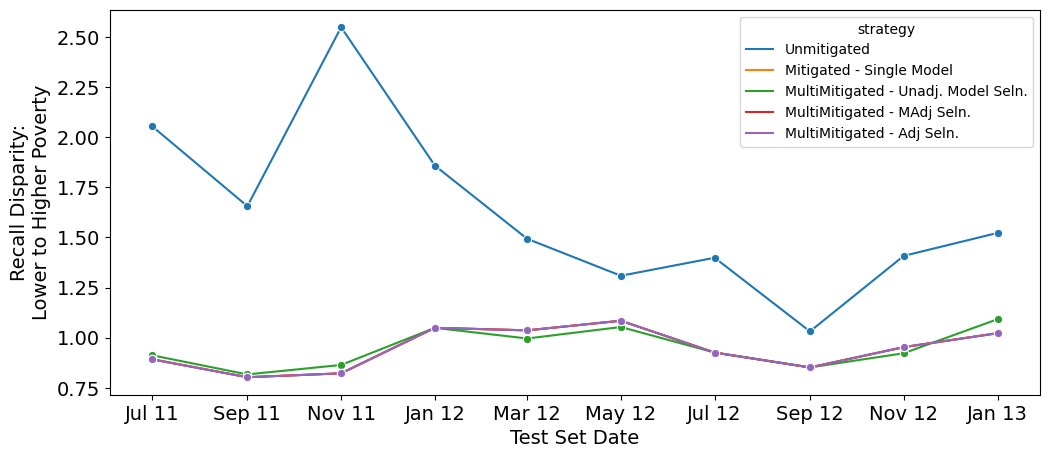

In [142]:
line_plot_over_time(y="recall_not_highest_to_highest", y_label='Recall Disparity:\nLower to Higher Poverty')

<AxesSubplot: xlabel='Test Set Date', ylabel='Fraction of list set to highest plevel'>

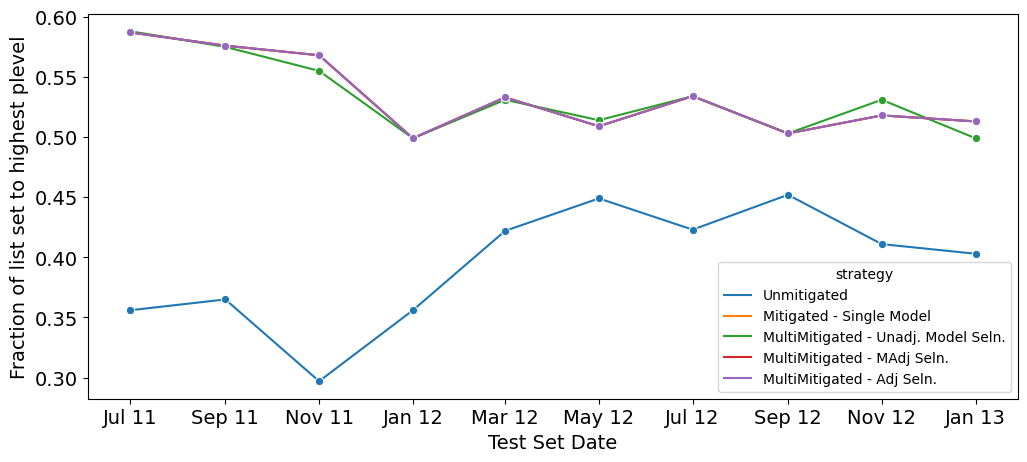

In [143]:
line_plot_over_time(y="frac_highest", y_label='Fraction of list set to highest plevel')

/tmp/ipykernel_9660/2634167029.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_val = grouped.mean()["value"]
/tmp/ipykernel_9660/2634167029.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std_val = grouped.std()["value"]
/tmp/ipykernel_9660/2634167029.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  c_mean_recp = grouped.mean()["recall_not_highest_to_highest"] - 1
/tmp/ipykernel_9660/2634167029.py:6: Fu

Text(0.5, 1.0, 'Mean Precision@1000')

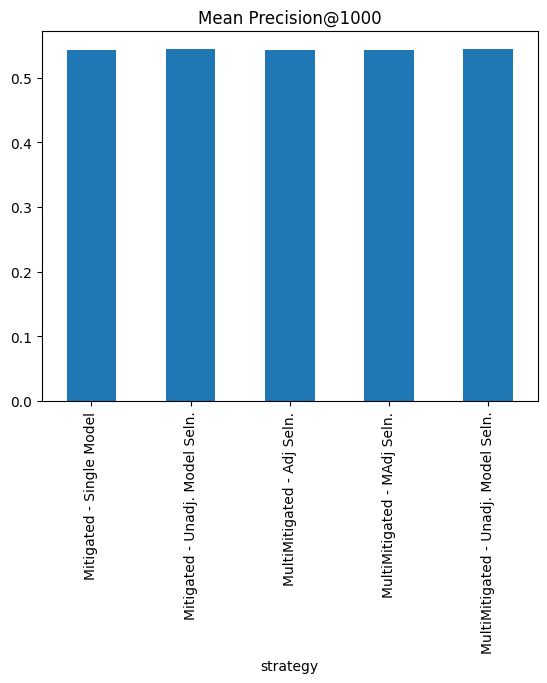

In [95]:
df = ts_df3.copy()[~ts_df3["strategy"].isin(["Unmitigated"])]
grouped = df.groupby("strategy")
mean_val = grouped.mean()["value"] 
std_val = grouped.std()["value"]
c_mean_recp = grouped.mean()["recall_not_highest_to_highest"] - 1
std_recp = grouped.std()["recall_not_highest_to_highest"]
mean_val.plot(kind="bar")
plt.title("Mean Precision@1000")

Text(0.5, 1.0, 'Mean Recall Parity - 1')

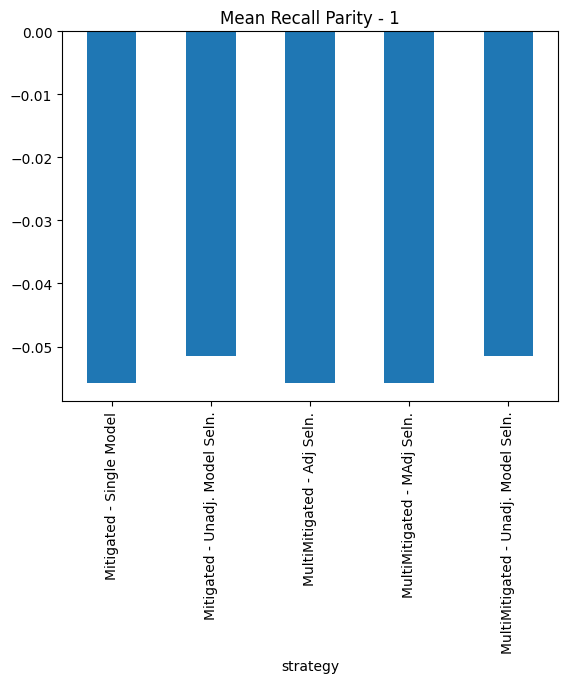

In [96]:
c_mean_recp.plot(kind="bar")
plt.title("Mean Recall Parity - 1")

Text(0.5, 1.0, 'Stdev Recall Parity')

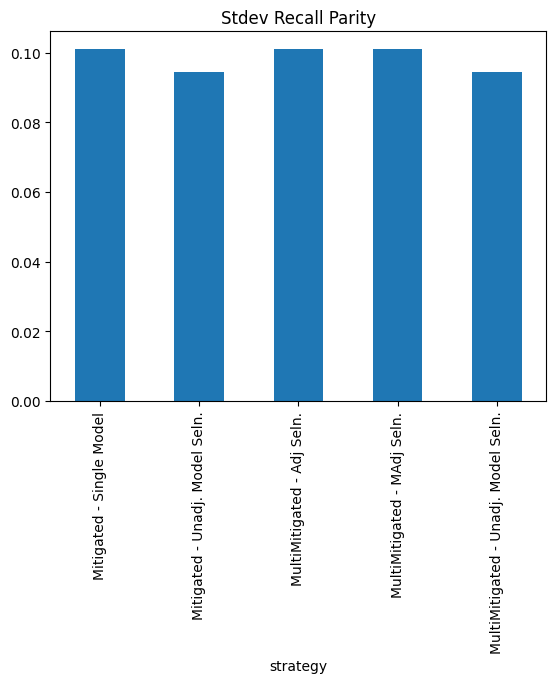

In [97]:
std_recp.plot(kind="bar", )
plt.title("Stdev Recall Parity")

### Figure 2 (Education Crowdfunding Points)
Comparing trade-offs across strategies

In [98]:
# renaming a few columns to ensure consistency across datasets
comp_df = ts_df3.rename(
    {'recall_not_highest_to_highest': 'recall_disp', 
     'frac_not_highest': 'frac_grp1', 
     'frac_highest': 'frac_grp2'
    }, axis='columns')

/tmp/ipykernel_9660/2835087850.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(),
/tmp/ipykernel_9660/2835087850.py:10: UserWarning: 
The markers list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(),


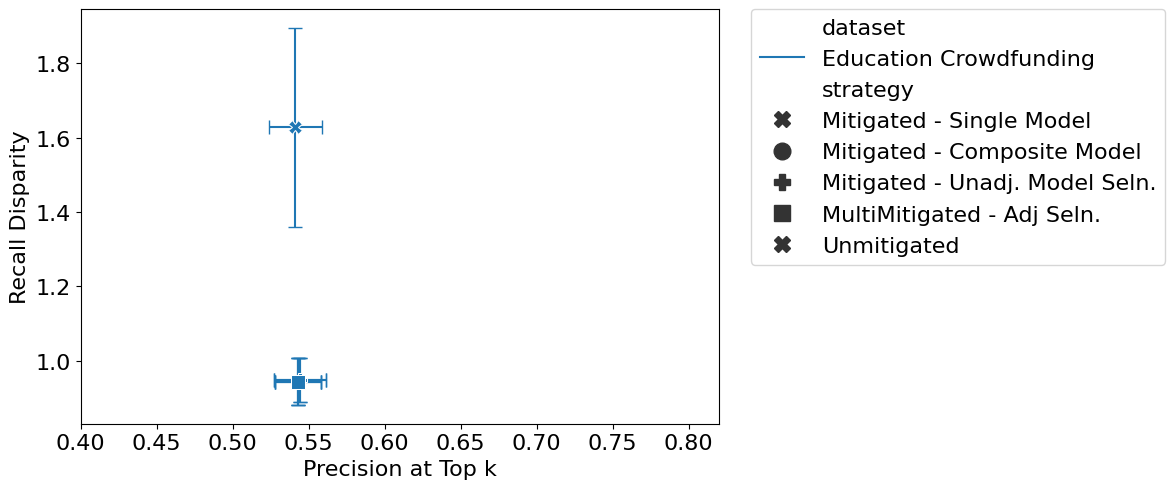

In [99]:
sty_ord = [
    'Mitigated - Single Model', 
    'Mitigated - Composite Model',
    'Mitigated - Unadj. Model Seln.',
    'MultiMitigated - Adj Seln.', 
    'Unmitigated'
]

fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
              style='strategy',
              style_order=sty_ord,
              markers=['X', 'o', 'P', 's'],
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.40,0.82))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)

fig.tight_layout()

### Figure 3 (Education Crowdfunding Points)
Comparing trade-offs across weights of multimitigation strategy

In [100]:
merged_df = get_merged_bias_results(engine_donors)

/tmp/ipykernel_9660/3255777266.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9660/3255777266.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9660/3255777266.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9660/3255777266.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9660/3255777266.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

In [101]:
merged_df.head()

,strategy,train_end_time,past_train_end_time,list_size,metric,parameter,value,max_recall_ratio,recall_not_highest_to_highest,frac_not_highest,frac_highest,min_score_not_highest,min_score_highest,mean_score_not_highest,mean_score_highest,precision_not_highest,precision_highest,prevalence_not_highest,prevalence_highest,positive_prevalence_not_highest,positive_prevalence_highest,positive_rate_not_highest,positive_rate_highest,dataset,weight
0,Unmitigated,2011-07-01,2011-03-01,1000,precision@,1000_abs,0.577,2.054736,2.054736,0.644,0.356,0.46930,0.46931,0.500954,0.499444,0.562112,0.603933,0.446653,0.553347,0.450379,0.549621,0.223745,0.220400,Education Crowdfunding,0.99
1,Unmitigated,2011-09-01,2011-05-01,1000,precision@,1000_abs,0.516,1.655690,1.655690,0.635,0.365,0.50949,0.50976,0.537848,0.539745,0.503937,0.536986,0.473745,0.526255,0.496497,0.503503,0.226856,0.207102,Education Crowdfunding,0.99
2,Unmitigated,2011-11-01,2011-07-01,1000,precision@,1000_abs,0.514,2.547976,2.547976,0.703,0.297,0.47061,0.47082,0.492843,0.492339,0.526316,0.484848,0.469197,0.530803,0.502098,0.497902,0.248908,0.218181,Education Crowdfunding,0.99
3,Unmitigated,2012-01-01,2011-09-01,1000,precision@,1000_abs,0.579,1.843866,1.843866,0.640,0.360,0.50048,0.50048,0.500717,0.500852,0.587500,0.563889,0.469429,0.530571,0.501130,0.498870,0.290544,0.255903,Education Crowdfunding,0.99
4,Unmitigated,2012-03-01,2011-11-01,1000,precision@,1000_abs,0.568,1.493166,1.493166,0.578,0.422,0.50044,0.50044,0.500630,0.500651,0.562284,0.575829,0.437847,0.562153,0.472494,0.527506,0.284848,0.247692,Education Crowdfunding,0.99


In [102]:
def line_plot_over_time_merged(y, y_label, ax=None, strategy="MultiMitigated - MAdj Seln."):
    df = merged_df[merged_df["strategy"] == strategy]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df, x='train_end_time', y=y, hue="weight", marker="o", ax=ax)

    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel('Test Set Date', fontsize=14)

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.get_legend()
    return ax

In [103]:
def line_plot_over_weight_merged(y, y_label, ax=None, strategy="MultiMitigated - MAdj Seln.", mean=True):
    df = merged_df[merged_df["strategy"] == strategy]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    
    grouped = df.groupby("weight")
    if mean:
        df = grouped.mean()
        title = f"{y_label} Mean"
    else:
        df = grouped.std()
        title = f"{y_label} Std"
    
    sns.lineplot(data=df, x=df.index, y=y, marker="o", ax=ax)

    ax.set_ylabel(f"{y_label} Mean", fontsize=14)
    ax.set_xlabel('Weight on t-2', fontsize=14)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(title)

    ax.get_legend()
    return ax

In [104]:
def best_metric_over_time(recall=True, strategy="MultiMitigated - MAdj Seln.", perc=0.05):
    def get_val(sli, weight, col):
        return sli[sli["weight"] == weight].reset_index()[col][0]
    
    fig, ax = plt.subplots(figsize=(12,5))
    df = merged_df[merged_df["strategy"] == strategy]
    df["temp_recall"] = abs(df["recall_not_highest_to_highest"]-1)
    times = list(df["train_end_time"].unique())
    weights = list(df["weight"].unique())
    
    value_ws = []
    value_add_times = []
    value_add_ws = []
    
    recall_ws = []
    recall_add_times = []
    recall_add_ws = []
    
    for timest in times:
        sl = df[df["train_end_time"] == timest]
        maxpos = sl["value"].idxmax()
        value_ws.append(sl.loc[maxpos, "weight"])
    
    for i, timest in enumerate(times):
        best_weight = value_ws[i]
        sl = df[df["train_end_time"] == timest]
        best_val = get_val(sl, best_weight, "value")
        lower = best_val * (1-perc)
        upper = best_val * (1+perc)
        for weight in weights:
            if weight != best_weight:
                val = get_val(sl, weight, "value")
                if lower <= val <= upper:
                    value_add_times.append(timest)
                    value_add_ws.append(weight)
            else:
                pass
        
    for timest in times:
        sl = df[df["train_end_time"] == timest]
        minpos = sl["value"].idxmin()
        recall_ws.append(sl.loc[minpos, "weight"])

        
    for i, timest in enumerate(times):
        best_weight = recall_ws[i]
        sl = df[df["train_end_time"] == timest]
        best_val = get_val(sl, best_weight, "temp_recall")
        lower = best_val * (1-perc)
        upper = best_val * (1+perc)
        for weight in weights:
            if weight != best_weight:
                val = get_val(sl, weight, "temp_recall")
                if lower <= val <= upper:
                    recall_add_times.append(timest)
                    recall_add_ws.append(weight)
            else:
                pass
    
    if not recall:
        sns.scatterplot(x=times, y=value_ws, label="Best Precision Weights", color='blue')
        sns.scatterplot(x=value_add_times, y=value_add_ws, label="Secondary Best Precision Weights", color='green')
    if recall:
        sns.scatterplot(x=times, y=recall_ws,label="Best Recall Parity Weights", color='red')
        sns.scatterplot(x=recall_add_times, y=recall_add_ws,label="Secondary Best Recall Parity Weights", color='orange')
    ax.set_title(f"Best Weight over Time (+- {perc*100}%)")
    ax.get_legend()
    ax.set_xlabel("Test Set Date")
    ax.set_ylabel("Weight")
    return ax

In [105]:
strategy="MultiMitigated - MAdj Seln."
df = merged_df[merged_df["strategy"] == strategy]
df["temp_recall"] = abs(df["recall_not_highest_to_highest"]-1)
times = list(df["train_end_time"].unique())
weights = list(df["weight"].unique())
value_ws = []
value_add_times = []
value_add_ws = []
recall_ws = []
for timest in times:
    sl = df[df["train_end_time"] == timest]
    maxpos = sl["value"].idxmax()
    value_ws.append(sl.loc[maxpos, "weight"])

/tmp/ipykernel_9660/3677588710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_recall"] = abs(df["recall_not_highest_to_highest"]-1)


## Comparing Metrics over time

<AxesSubplot: xlabel='Test Set Date', ylabel='Precision @1000'>

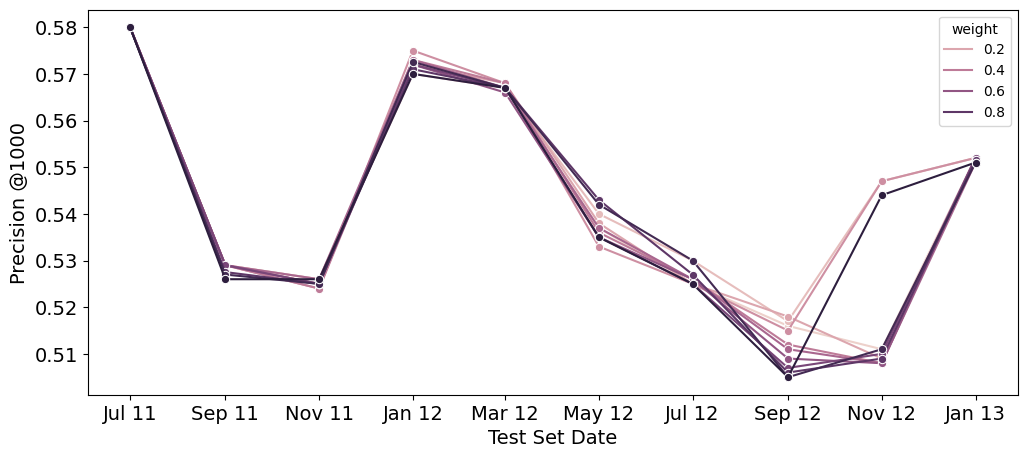

In [106]:
line_plot_over_time_merged(y="value", y_label='Precision @1000')

<AxesSubplot: xlabel='Test Set Date', ylabel='Recall Disparity:\nLower to Higher Poverty'>

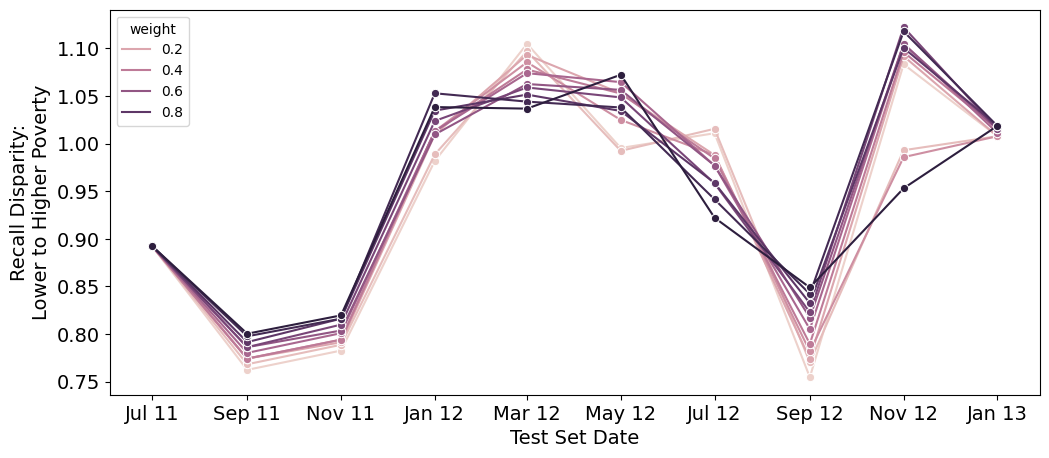

In [107]:
line_plot_over_time_merged(y="recall_not_highest_to_highest", y_label='Recall Disparity:\nLower to Higher Poverty')

<AxesSubplot: xlabel='Test Set Date', ylabel='Fraction of list set to highest plevel'>

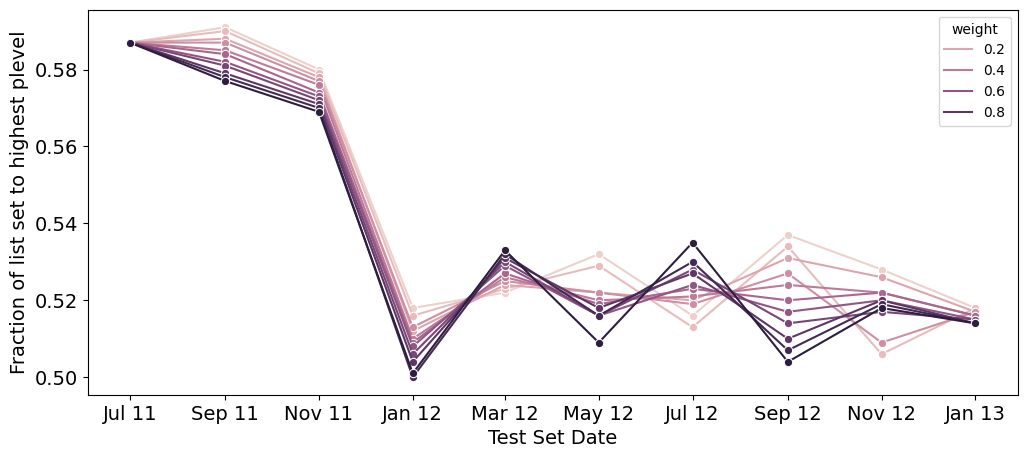

In [108]:
line_plot_over_time_merged(y="frac_highest", y_label='Fraction of list set to highest plevel')

# Best Weight Per Time Stamp

/tmp/ipykernel_9660/1535745390.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_recall"] = abs(df["recall_not_highest_to_highest"]-1)


<AxesSubplot: title={'center': 'Best Weight over Time (+- 5.0%)'}, xlabel='Test Set Date', ylabel='Weight'>

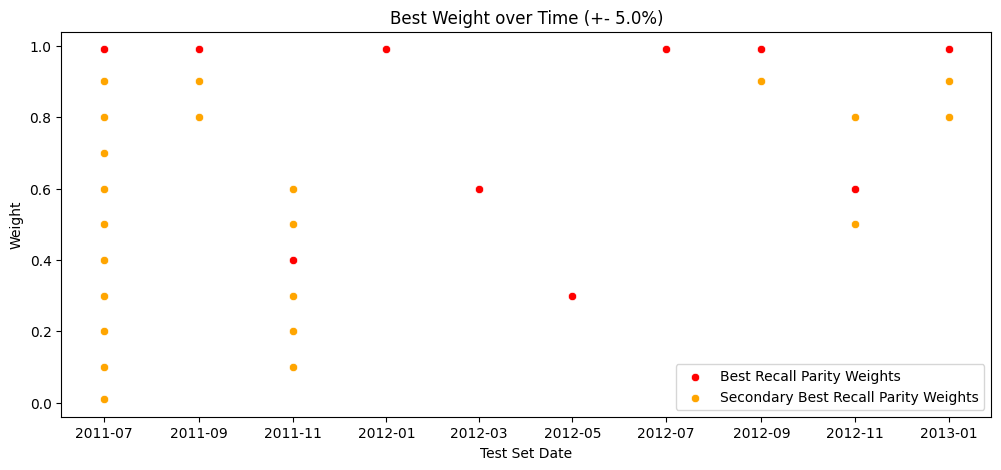

In [109]:
best_metric_over_time()

/tmp/ipykernel_9660/1535745390.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temp_recall"] = abs(df["recall_not_highest_to_highest"]-1)


<AxesSubplot: title={'center': 'Best Weight over Time (+- 5.0%)'}, xlabel='Test Set Date', ylabel='Weight'>

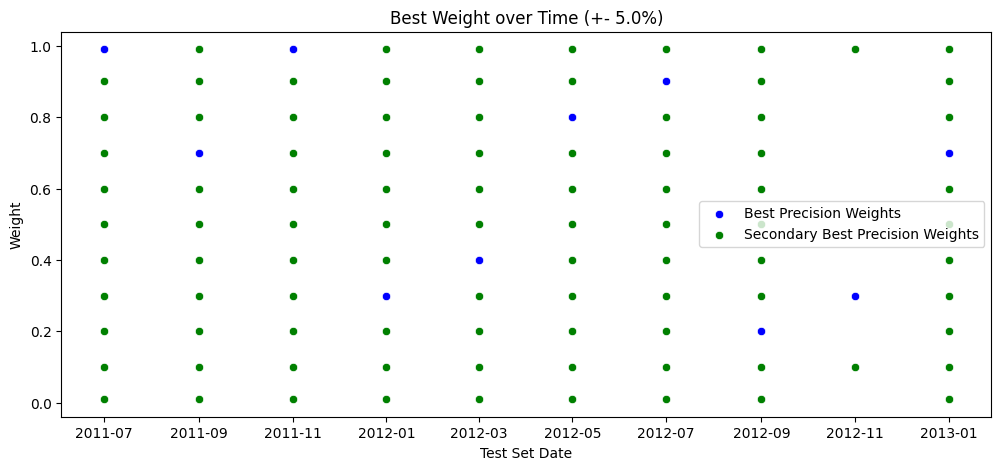

In [110]:
best_metric_over_time(recall=False)

/tmp/ipykernel_9660/2433029346.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grouped.mean()


<AxesSubplot: title={'center': 'Recall Disparity:\nLower to Higher Poverty Mean'}, xlabel='Weight on t-2', ylabel='Recall Disparity:\nLower to Higher Poverty Mean'>

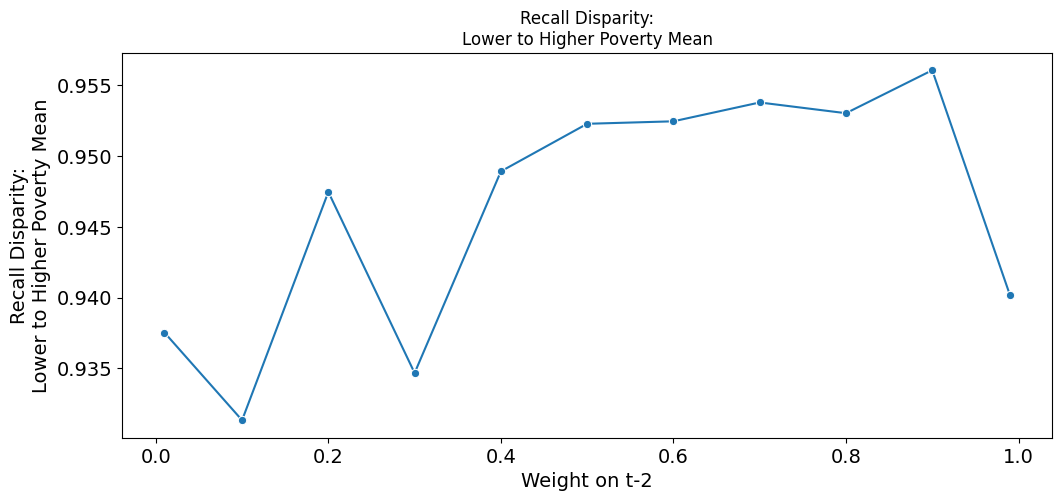

In [111]:
line_plot_over_weight_merged(y="recall_not_highest_to_highest", y_label='Recall Disparity:\nLower to Higher Poverty', mean=True)

/tmp/ipykernel_9660/2433029346.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grouped.std()


<AxesSubplot: title={'center': 'Recall Disparity:\nLower to Higher Poverty Std'}, xlabel='Weight on t-2', ylabel='Recall Disparity:\nLower to Higher Poverty Mean'>

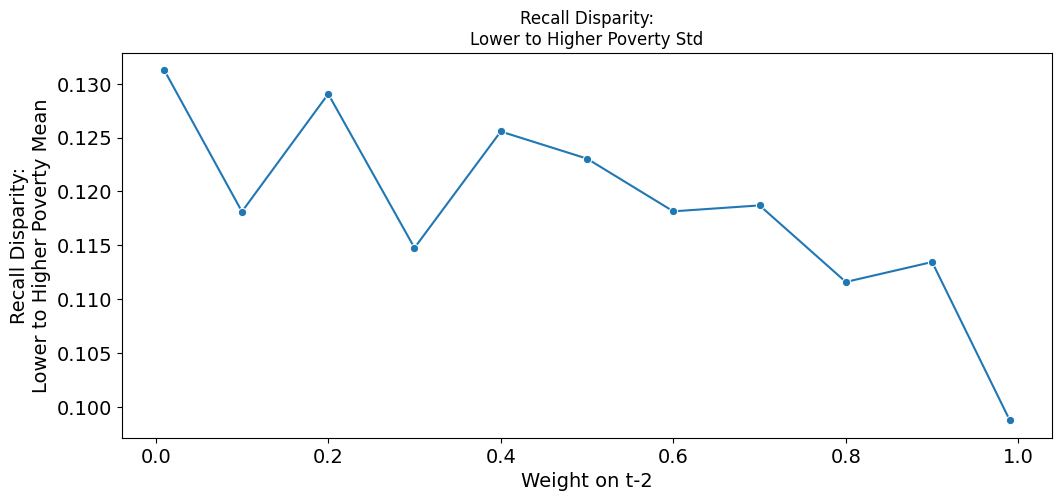

In [112]:
line_plot_over_weight_merged(y="recall_not_highest_to_highest", y_label='Recall Disparity:\nLower to Higher Poverty', mean=False)

/tmp/ipykernel_9660/2433029346.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grouped.mean()


<AxesSubplot: title={'center': 'Fraction of list set to highest plevel Mean'}, xlabel='Weight on t-2', ylabel='Fraction of list set to highest plevel Mean'>

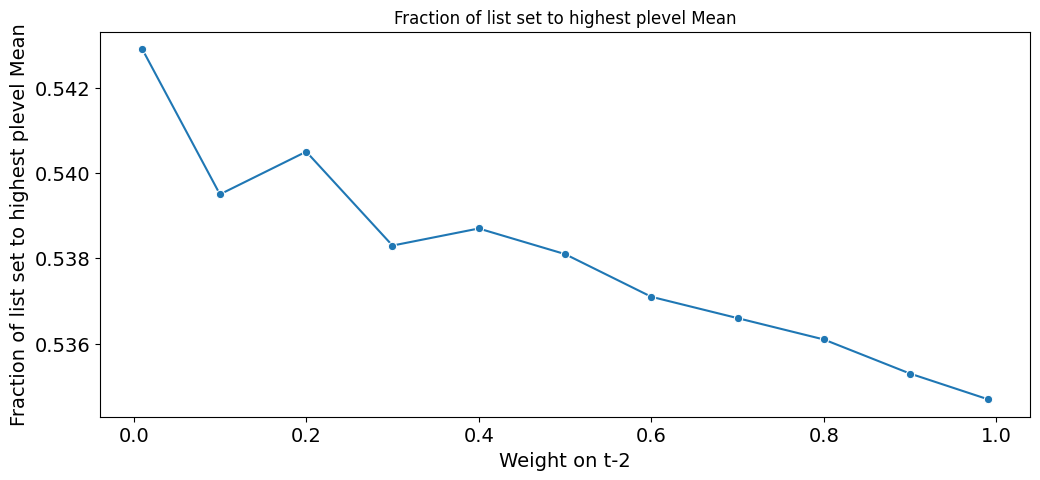

In [113]:
line_plot_over_weight_merged(y="frac_highest", y_label='Fraction of list set to highest plevel', mean=True)

/tmp/ipykernel_9660/2433029346.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grouped.std()


<AxesSubplot: title={'center': 'Fraction of list set to highest plevel Std'}, xlabel='Weight on t-2', ylabel='Fraction of list set to highest plevel Mean'>

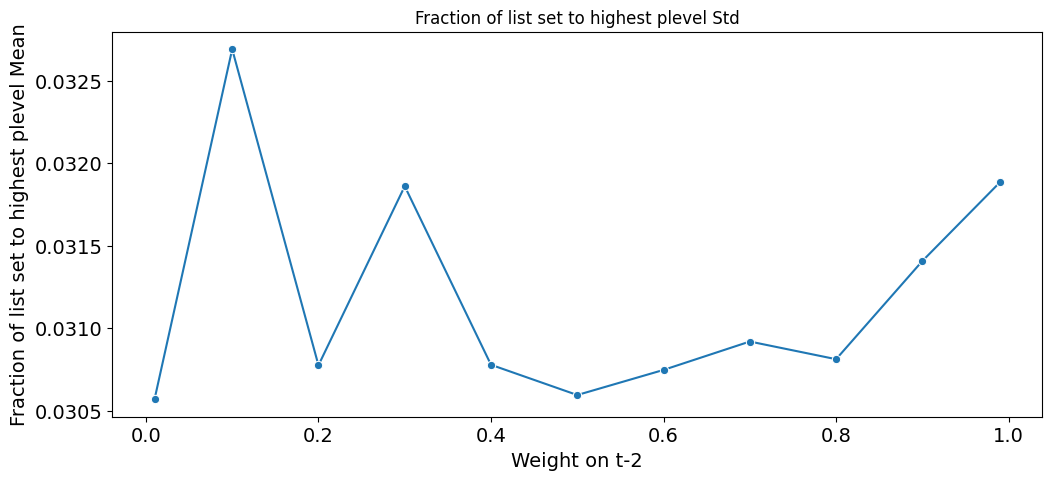

In [114]:
line_plot_over_weight_merged(y="frac_highest", y_label='Fraction of list set to highest plevel', mean=False)

# Exhaustive Analysis of Sensitivity

In [115]:
exhaustive_df = get_exhaustive_results(engine_donors)

/tmp/ipykernel_9660/3062825757.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9660/3062825757.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9660/3062825757.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9660/3062825757.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp_df, ignore_index=True)
/tmp/ipykernel_9660/3062825757.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

In [116]:
def line_plot_over_time_exhaustive(y, y_label, ax=None, strategy="Mitigated - Single Model"):
    df = exhaustive_df[exhaustive_df["strategy"] == strategy]
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df, x='train_end_time', y=y, hue="ex_id", marker="o", ax=ax)

    ax.set_ylabel(y_label, fontsize=14)
    ax.set_xlabel('Test Set Date', fontsize=14)

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.get_legend()
    return ax

<AxesSubplot: xlabel='Test Set Date', ylabel='Fraction of list set to highest plevel'>

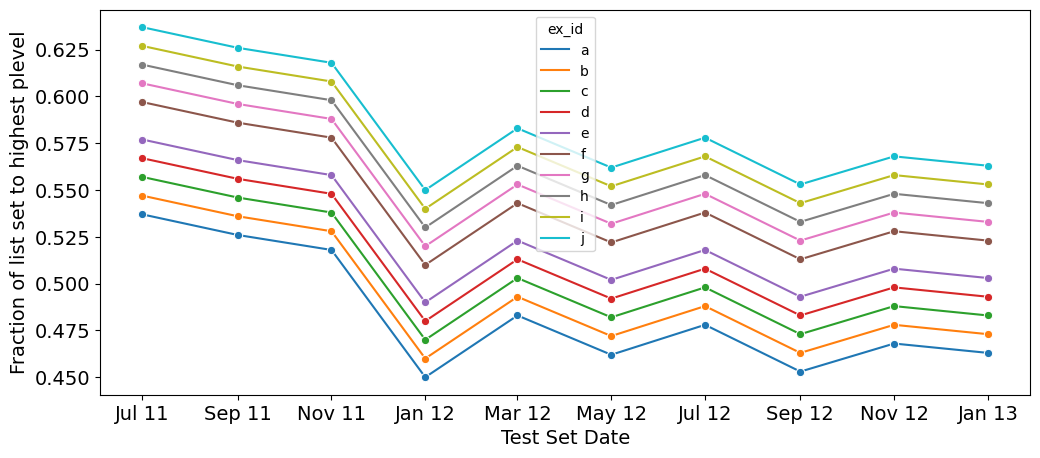

In [117]:
line_plot_over_time_exhaustive(y="frac_highest", y_label='Fraction of list set to highest plevel')

<AxesSubplot: xlabel='Test Set Date', ylabel='Precision @ 1000'>

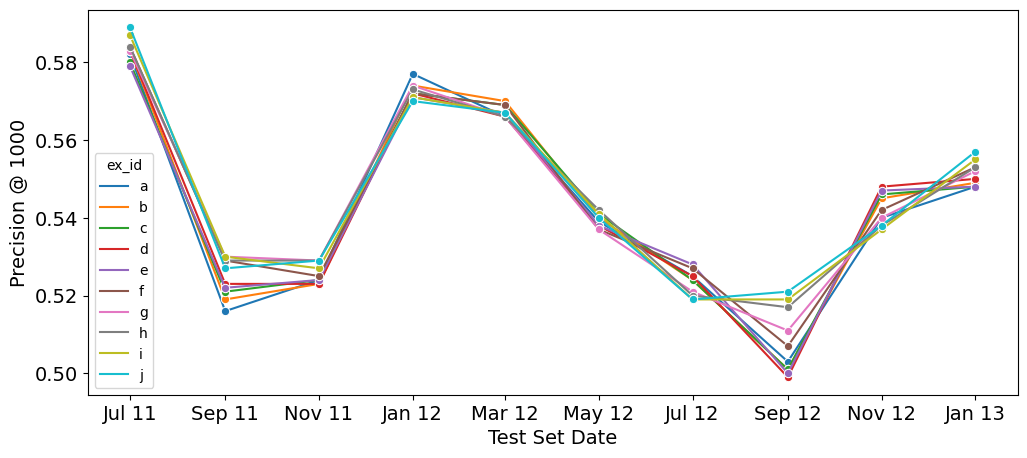

In [118]:
line_plot_over_time_exhaustive(y="value", y_label='Precision @ 1000')

<AxesSubplot: xlabel='Test Set Date', ylabel='Recall Disparity:\nLower to Higher Poverty'>

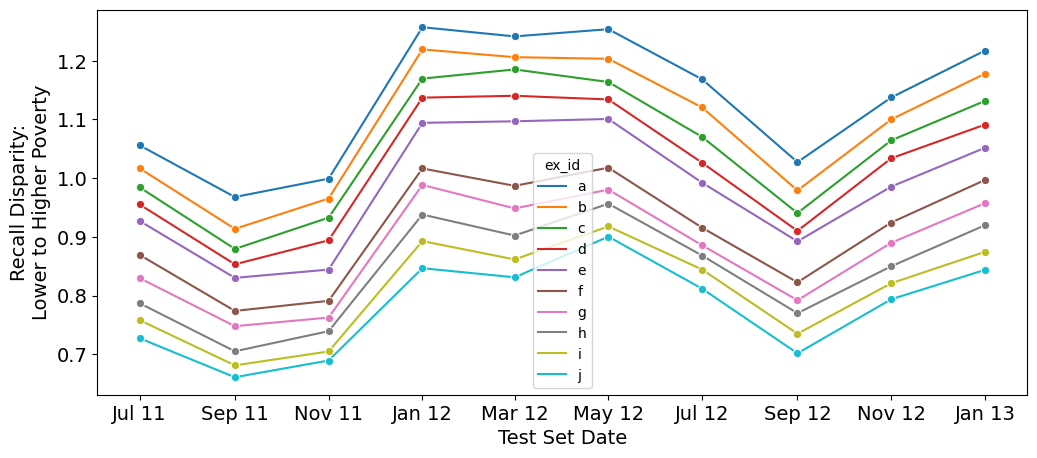

In [119]:
line_plot_over_time_exhaustive(y="recall_not_highest_to_highest", y_label='Recall Disparity:\nLower to Higher Poverty')

# Self Adjusted Analysis

<AxesSubplot: xlabel='Test Set Date', ylabel='Precision @1000'>

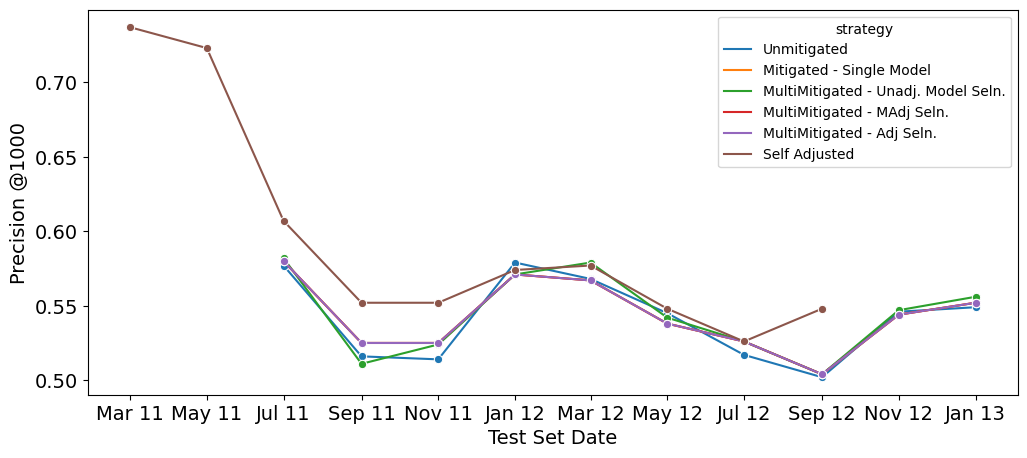

In [147]:
line_plot_over_time(y="value", y_label='Precision @1000', strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln.", "Self Adjusted"])

<AxesSubplot: xlabel='Test Set Date', ylabel='Fraction of list set to highest plevel'>

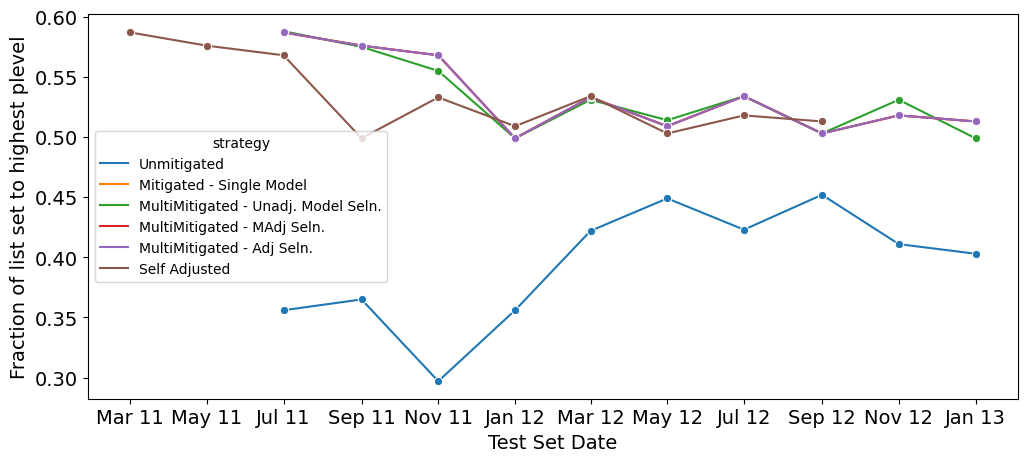

In [146]:
line_plot_over_time(y="frac_highest", y_label='Fraction of list set to highest plevel', strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln.", "Self Adjusted"])

<AxesSubplot: xlabel='Test Set Date', ylabel='Recall Disparity:\nLower to Higher Poverty'>

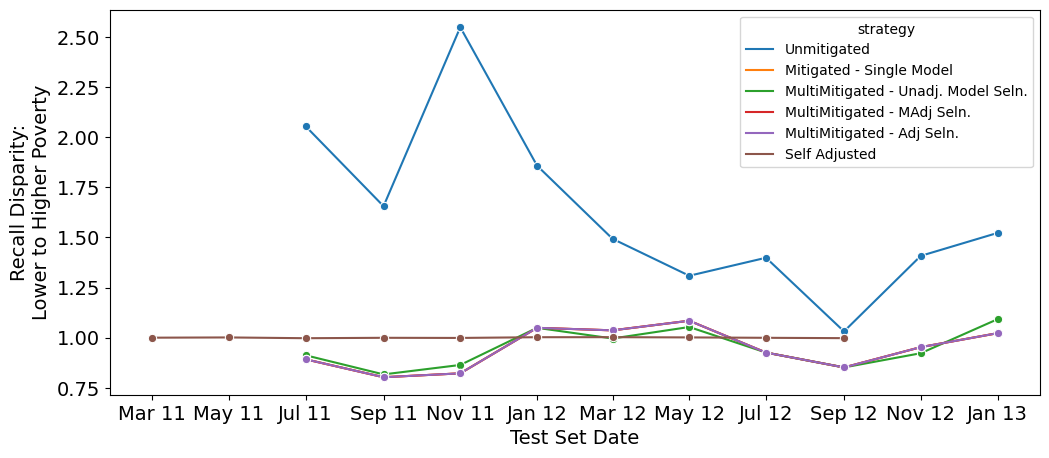

In [145]:
line_plot_over_time(y="recall_not_highest_to_highest", y_label='Recall Disparity:\nLower to Higher Poverty', strategies=["Unmitigated", "Mitigated - Single Model", "MultiMitigated - Adj Seln.", "MultiMitigated - MAdj Seln.", "MultiMitigated - Unadj. Model Seln.", "Self Adjusted"])

# Reproducing the Bias Adjustments

The following code will re-run the bias analysis itself starting from the model results. Note that there is some randomness in the code (breaking ties between projects with the same score as well as breaking ties between models with the same performance on a given test set), so the results you get here may not be exactly identical to the results above, but should be statistically consistent with them.

**NOTE: Running all of the results here can take a fair amount of time (around 2-3 hours on a db.m5.2xlarge AWS RDS instance), so be sure to be working in a screen/tmux setting if running the notebook remotely!**

Currently, this code assumes your data is in a postgres database containing modeling results in the format of our open-source `triage` machine learning pipeline, including temporal validation splits.


Next, let's clear out anything in the `bias_results` schema (these should start empty, unless you've already run anything since loading the database):

In [6]:
engine_donors.execute('TRUNCATE TABLE bias_results.composite_results_plevel;')
engine_donors.execute('TRUNCATE TABLE bias_results.model_adjustment_results_plevel;')
engine_donors.execute('TRUNCATE TABLE bias_working.model_adjustment_group_k_plevel;')
engine_donors.execute('COMMIT;')

In [7]:
from DJRecallAdjuster import education_ra_procedure

In [8]:
weights = [1, 0]

In [9]:
education_ra_procedure(weights=weights, pause_phases=False)

[('2011-03-01', '2011-03-01'), ('2011-03-01', '2011-07-01')]
Date Pair: [('2011-03-01', '2011-03-01'), ('2011-03-01', '2011-07-01')] pre sql done


KeyboardInterrupt: 

If you want to explore the results further, `bias_results.model_adjustment_results_plevel` holds the results from your run for each model, including the validation set the thresholds were learned based on (`past_train_end_time`), the validation set they were applied to (`train_end_time`), and the unadjusted (`base_` columns) and adjusted (`adj_` columns) results in terms of accuracy, disparities, and the composition of the selected list. The `bias_results.composite_results_plevel` has a similar structure for the composite models created by selecting the best-performing model for each subgroup separately (so note there's no overall `model_id` ehre, but separate columns for the model group used for each subgroup)



In [ ]:
pd.read_sql("SELECT * FROM bias_results.model_adjustment_results_plevel LIMIT 5", engine_donors)